In [2]:
# Step 1: Load your dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout



In [3]:
# Load your dataset
data_count = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data.csv', parse_dates=[0])

# Step 2: Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_count[['AverageTemperature', 'Year', 'Month', 'TemperatureAnomaly', 'YearlyAvgTemperature']])

# Step 3: Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Sequence length (e.g., using data from the last 12 months)
X, y = create_sequences(data_scaled, SEQ_LENGTH)



In [4]:
# Step 4: Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape X for Conv1D (CNN requires input shape: (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))



In [6]:
# Step 5: Build the CNN-LSTM Model
model = Sequential()

# Add Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

# Add LSTM layer directly (no Flatten layer here)
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Add Dense output layer
model.add(Dense(1))  # Output is a single temperature value

# Step 6: Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 8: Evaluate the Model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 9: Make Predictions
y_pred = model.predict(X_test)


Epoch 1/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0129 - val_loss: 0.0026
Epoch 2/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 6/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 7/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 11/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 12/20
5247/52

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

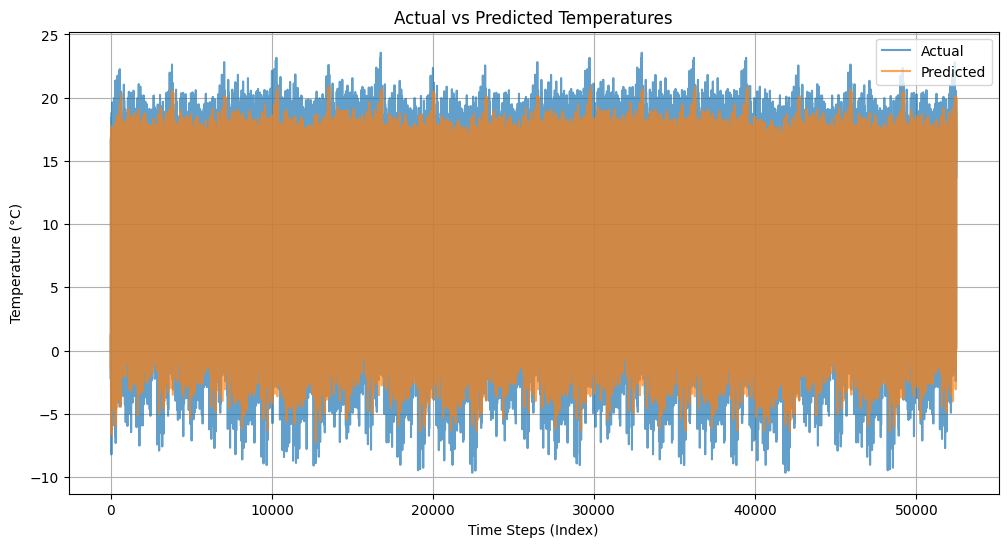

In [9]:
# Step 10: Inverse Transform Predictions and Actual Values

# Expand y_test and y_pred to match the scaler's expected input shape
y_test_expanded = np.zeros((len(y_test), data_scaled.shape[1]))
y_pred_expanded = np.zeros((len(y_pred), data_scaled.shape[1]))

# Place y_test and y_pred in the first column
y_test_expanded[:, 0] = y_test
y_pred_expanded[:, 0] = y_pred.flatten()

# Inverse transform using the scaler
y_test_unscaled = scaler.inverse_transform(y_test_expanded)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_expanded)[:, 0]

# Step 11: Plot Actual vs Predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred_unscaled, label='Predicted', alpha=0.7)
plt.xlabel('Time Steps (Index)')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 1.0645216261102188


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 1.3898880345047357


In [12]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f"R² Score: {r2}")


R² Score: 0.957813009966079


In [13]:
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Percentage Error (MAPE): 75.039802989247%


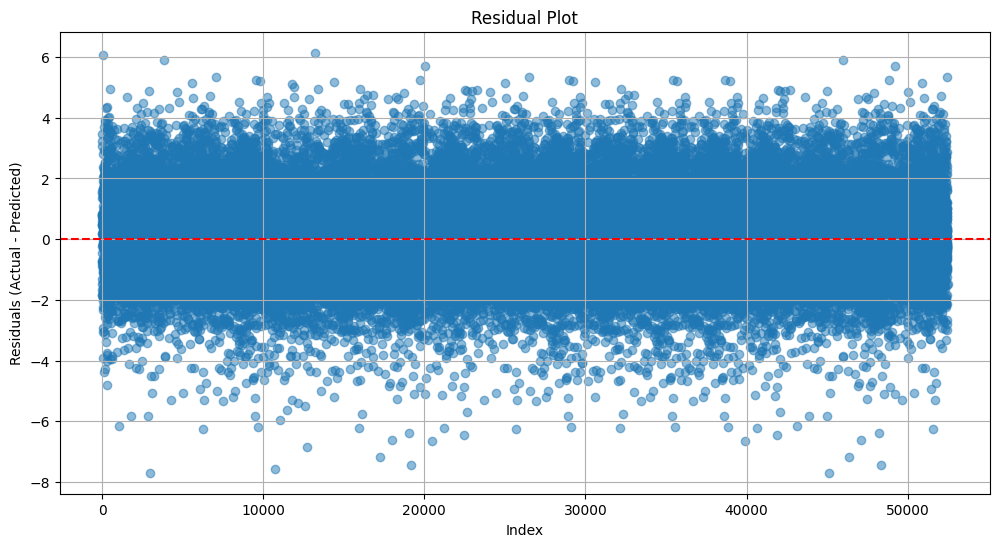

In [14]:
# Residuals
residuals = y_test_unscaled - y_pred_unscaled

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


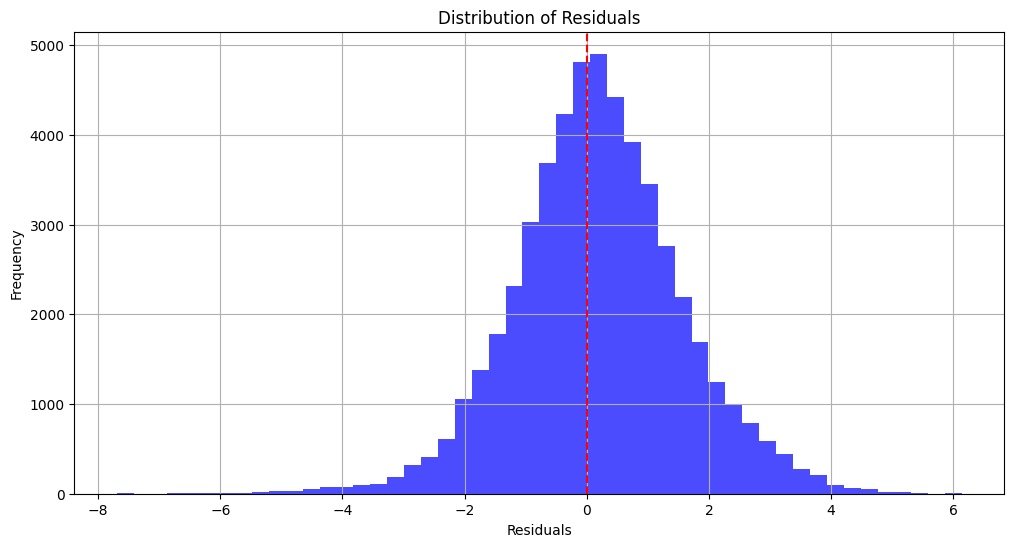

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


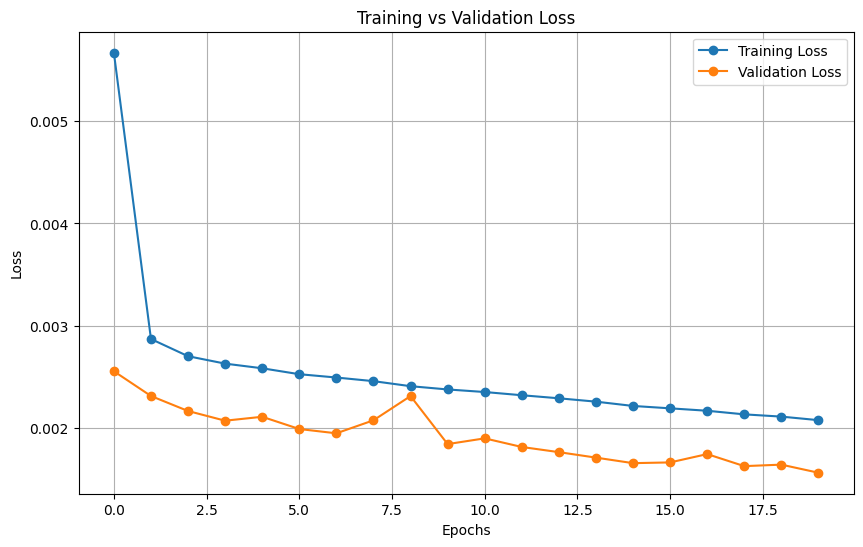

: 

In [16]:
# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
